In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ast import literal_eval
from glob import glob
import pandas as pd

In [3]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


def preprocessRawStrokes(raw_strokes):
    """ process raw input strokes from .csv file.
    Stack all stroke vector to a Nx3 array. c_stroke[:,2] indicates if this is a start of a new stroke vector
    with 1 or 2. Then make all strokes the same length
    """
    stroke_vec = literal_eval(raw_strokes) # read stroke string vector to list
    
    # unwrap the list
    in_strokes = [(xi, yi, i) for i, (x, y) in enumerate(stroke_vec) for xi, yi in zip(x,y)]    
    c_strokes = np.stack(in_strokes)

    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1] + np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    
    # make all strokes same length by padding the strokes with zero after
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=196, 
                         padding='post').swapaxes(0, 1)


def read_batch(path, samples=5, 
               start_row=0,
               n_rows=1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in path:
        c_df = pd.read_csv(c_path, nrows=n_rows, skiprows=start_row)
        c_df.columns=['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].map(preprocessRawStrokes)
    
    return full_df

Using TensorFlow backend.


In [10]:
def generateDf(n_train, n_valid, n_test, n_strokes, path):
    """ for each .csv file randomly sample 750 training instances, 
    75 valid instances, and 50 test instances """
    
    # TODO
    train_args = dict(samples=n_train, start_row=0, n_rows=int(n_train*1.5), path=path)
    valid_args = dict(samples=n_valid, start_row=train_args['n_rows']+1, n_rows=n_valid+25, path=path)
    test_args = dict(samples=n_test, start_row=valid_args['n_rows']+train_args['n_rows']+1, 
                     n_rows=n_test+25, path=path)

    train_df = read_batch(**train_args)
    valid_df = read_batch(**valid_args)
    test_df = read_batch(**test_args)

    word_encoder = LabelEncoder()
    word_encoder.fit(train_df['word'])

#     print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))
    return train_df, valid_df, test_df, word_encoder

In [16]:
def getXYfromDf(df, word_encoder):
    """ Generate feature x and label y for input dataframe 
    """
    x = np.stack(df['drawing'], axis=0)
    y = to_categorical(word_encoder.transform(df['word'].values))
    return x, y

In [17]:
def demo():
    """ demonstarte how a pic made up of stroke vectors
    Each stroke_idx represents a stroke
    """
    base_dir = '/Volumes/JS/QuickDraw'
    test_path = os.path.join(base_dir, '/test_simplified.csv')
    all_train_paths = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
#     cols = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
    train_df, valid_df, test_df, word_encoder = generateDf(n_train=750, n_valid=75, n_test=50, 
                                                       n_strokes=196, path=all_train_paths)
    x_train, y_train = getXYfromDf(train_df, word_encoder)
    x_valid, y_valid = getXYfromDf(valid_df, word_encoder)
    x_test, y_test = getXYfromDf(test_df, word_encoder)

    fig, m_axs = plt.subplots(3, 3, figsize=(16, 16))
    rand_idxs = np.random.choice(range(x_train.shape[0]), size = 9)

    for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
        test = x_train[c_id]
        test = test[test[:,2] > 0, :]  # when the stroke index=0 means it's invalid generate by padding 0
        stroke_idx = np.cumsum(test[:,2] - 1)
        for i in np.unique(stroke_idx):   # visualize each stroke vector
            c_ax.plot(test[stroke_idx==i,0], np.max(test[:,1]) - test[stroke_idx==i,1], '.-')
#         c_ax.axis('off')   # display axis or not
        c_ax.set_title(word_encoder.classes_[np.argmax(y_train[c_id])])

words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

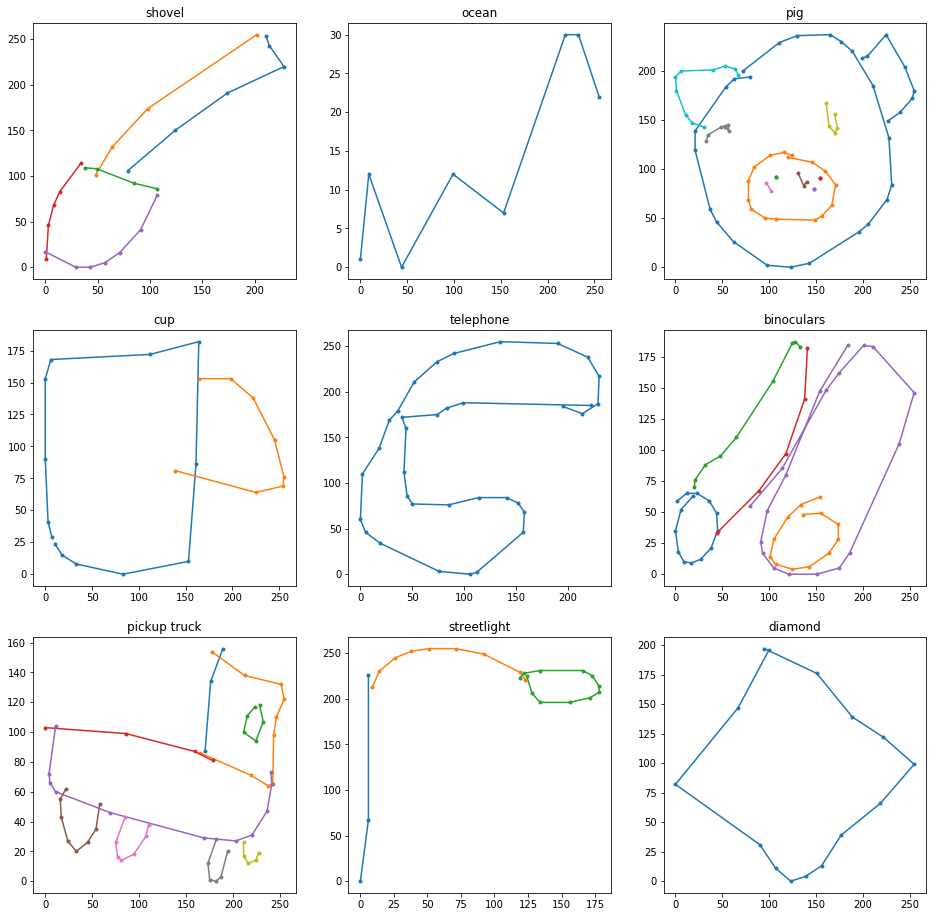

In [18]:
demo()